In [ ]:
# Implement Gaussian 

In [5]:
import pymc3 as pm
import numpy as np
import scipy as sp
import pandas as pd
import theano
import theano.tensor as tt

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv('df_concat.csv')

In [7]:
df.columns

Index(['Unnamed: 0', 'PrevClinName1', 'ClinCityCode', 'ClinStateCode', 'Year',
       'ICSI_Rate', 'PGD_Rate', 'ND_TransLB1', 'ND_TransLB2', 'ND_TransLB3',
       'ND_TransLB4', 'TotNumCyclesAll', 'TransFrozEmbAll', 'ClinicNames'],
      dtype='object')

In [ ]:
# Convert years to 0 to 10
dic_year = {2008:0,2009:1,2010:2,2011:3,2012:4,2013:5,2014:6,2015:7,2016:8,2017:9,2018:10}
def convert_year(df):
    list_of_years =[]
    for y in df['Year']:
        list_of_years.append(dic_year[y])
        
    df['NewYear'] = list_of_years

In [ ]:
def add_clinic_id(df):
    n=0
    clinic_dict = {}
    # Create unique ID for each clinic
    for name in df['ClinicNames']:
        if name not in clinic_dict:
            clinic_dict.update({name:n})
            n += 1
            
    # Add column to df
    list_of_ids = []
    for name in df['ClinicNames']:
        list_of_ids.append(clinic_dict[name])
    df['ClinicID'] = list_of_ids
    return df

In [6]:
# X must be a column vector

In [29]:
y = df[df.ClinicNames=='CLEVELAND CLINIC FERTILITY CENTER BEACHWOOD']['ND_TransLB1']
X = df[df.ClinicNames=='CLEVELAND CLINIC FERTILITY CENTER BEACHWOOD']['Year']

In [30]:
X = X.values.reshape(-1,1)

In [52]:
y_sd = y.std()
y_mu = y.mean()

In [35]:
y = y.values

In [50]:
y_sd

6.540136728674108

In [38]:
with pm.Model() as model:
    nu = pm.HalfNormal("nu", sd=5)
    tao = pm.Gamma("tao", alpha=2, beta=0.25)
    cov = nu**2 * pm.gp.cov.Matern32(1, tao)
    gp = pm.gp.Marginal(cov_func=cov)

    # y reporting uncertainty
    #y_err = pm.Normal("y_err", mu=np.mean(y), sd=5, shape=len(X))
    y_err = pm.Normal("y_err", mu=0.0, sd=7, shape=len(X))
    y_uncert = y - y_err

    # white noise variance
    sigma = pm.HalfNormal("sigma", sd=5, testval=1)
    y_ = gp.marginal_likelihood("y", X=X, y=y_uncert, noise=sigma)

/Users/jacobberger/anaconda3/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x


In [39]:
with model:
    tr = pm.sample(1000, chains=2, cores=1,target_accept=.9, discard_tuned_samples=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/Users/jacobberger/anaconda3/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
/Users/jacobberger/anaconda3/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
/Users/jacobberger/anaconda3/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional i

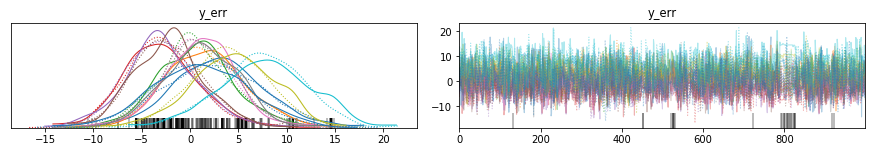

In [41]:
pm.traceplot(tr, varnames=["y_err"]);

In [46]:
#tnew = np.linspace(-100, 2150, 2000)/100
tnew = np.linspace(2007, 2020, 14)
with model:
    ffnew = gp.conditional("ffnew", Xnew=tnew[:,None])

with model:
    ppc = pm.sample_ppc(tr, samples=2000, vars=[ffnew])

/Users/jacobberger/anaconda3/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
/Users/jacobberger/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: sample_ppc() is deprecated.  Please use sample_posterior_predictive()
  import sys
  0%|          | 0/2000 [00:00<?, ?it/s]/Users/jacobberger/anaconda3/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
/

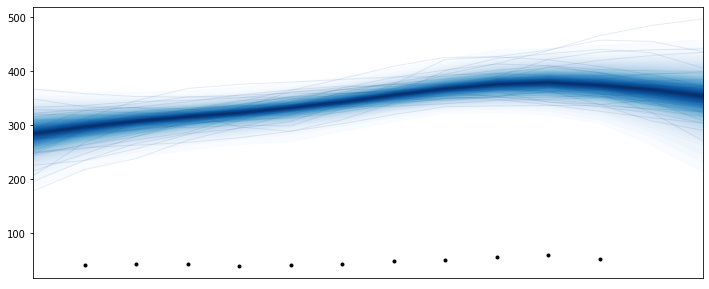

In [53]:
samples = y_sd * ppc["ffnew"] + y_mu

fig = plt.figure(figsize=(12,5))
ax = plt.gca()
pm.gp.util.plot_gp_dist(ax, samples, tnew, plot_samples=True, palette="Blues")
ax.plot(X, y, "k.");
ax.set_xticks(np.arange(0,14));
ax.set_xlim([2007, 2020]);

In [ ]:
clinic_idx = df_test.ClinicID.values

with pm.Model() as hierarchical_model:
    
    # Hyperpriors for group nodes
    mu_a = pm.Normal('mu_alpha', mu=0., sigma=1)
    sigma_a = pm.HalfCauchy('sigma_alpha', beta=10)
    
    mu_b = pm.Normal('mu_beta', mu=0., sigma=1)
    sigma_b = pm.HalfCauchy('sigma_beta', beta = 10)

    # Intercept for each clinic, distributed around group mean mu_a
    # Above we just set mu and sd to a fixed value while here we
    # plug in a common group distribution for all a and b (which are
    # vectors of length n_clinics).
    
    a = pm.Normal('alpha', mu=mu_a, sigma=sigma_a, shape=len(df_test.ClinicNames.unique()))
    # Slope for each county, distributed around group mean mu_b
    b = pm.Normal('beta', mu=mu_b, sigma=sigma_b, shape=len(df_test.ClinicNames.unique()))
    
    # Add other priors
    

    # Model error
    eps = pm.HalfCauchy('eps', 5.)

    success_est = (a[clinic_idx] +
                   b[clinic_idx]*df_test.NewYear.values)

    # Data likelihood
    success_like = pm.Normal('success_like', mu=success_est,
                           sigma=eps, observed=df_test.ND_TransLB1)